
#**CIS 545 Final Project: Worldwide Health Trends - Extra Visuals & Models**

> **Fall** **2020** **| By: Ke (Coco) Zhao & Yathushan (Yathu) Nadanapathan**


# Data Loading and Wrangling

---



In [ ]:
!pip3 install pandas

In [ ]:
!pip install pycountry-convert
!pip install geopandas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import geopandas
import torch
import itertools
from datetime import datetime
from matplotlib import rcParams
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.stats import f_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from itertools import permutations  


## Load Data


In [ ]:
url = 'https://drive.google.com/file/d/1DyotpOB9xTku131LatNJla6Rx8_RBdQX/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
health = pd.read_csv(path)
health = health.drop_duplicates()
cleaned_health = health.dropna(axis=1, how='all')

## Data Wrangling


In [ ]:
pivoted_health = pd.DataFrame()

for i in range(1960, 2016):
  health_2 = health[["Indicator Name", "Country Name", str(i)]]
  health_2
  health_3 = health_2.pivot(index='Country Name', columns='Indicator Name')
  health_3.columns = health_3.columns.droplevel(0)
  health_3["Year"] = str(i)
  pivoted_health = pivoted_health.append(health_3)

#pivoted_health

In [ ]:
#function to convert to alpah2 country codes and continents
y = pivoted_health.reset_index()

x = y["Country Name"].unique()
x = x.tolist()

continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : "Europe",
    "Unknown" : "Unknown"
}

continent_map = {}

def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    
    y = continents[cn_continent]
    continent_map[col] = continents[cn_continent]
    return (col, y)

#[continents[country_alpha2_to_continent_code(country)] for country in codes]
codes = [get_continent(country) for country in x]

continent_map["Arab World"] = "Asia"
continent_map['Bahamas, The'] = "North America"
continent_map['Caribbean small states'] = "North America"
continent_map['Central Europe and the Baltics'] = "Europe"
continent_map['Channel Islands'] = "Europe"
continent_map['Congo, Dem. Rep.'] = "Africa"
continent_map['Congo, Rep.'] = "Africa"
continent_map["Cote d'Ivoire"] = "Africa"
continent_map["Curacao"] = "South America"
continent_map["East Asia & Pacific"] = "Asia"
continent_map['Egypt, Arab Rep.'] = "Africa"
continent_map['European Union'] = "Europe"
continent_map['Gambia, The'] = "Africa"
continent_map['Hong Kong SAR, China'] = "Asia"
continent_map['Korea, Dem. People’s Rep.'] = "Asia"
continent_map['Korea, Rep.'] = "Asia"
continent_map['Kosovo'] = "Europe"
continent_map['Lao PDR'] = "Asia"
continent_map['Macao SAR, China'] = "Asia"
continent_map['Macedonia, FYR'] = "Europe"
continent_map['Micronesia, Fed. Sts.'] = "Australia"
continent_map['Middle East & North Africa'] = "Africa"
continent_map['North America'] = "North America"
continent_map['South America'] = "South America"
continent_map['Sint Maarten (Dutch part)'] = "North America"
continent_map['South Asia'] = "Asia"
continent_map['St. Martin (French part)'] = "North America"
continent_map['St. Vincent and the Grenadines'] = "North America"
continent_map['Sub-Saharan Africa'] = "Africa"
continent_map['Timor-Leste'] = "Asia"
continent_map['Venezuela, RB'] = "South America"
continent_map['Virgin Islands (U.S.)'] = "North America"
continent_map['West Bank and Gaza'] = "Asia"
continent_map['Yemen, Rep.'] = "Asia"

In [ ]:
pivoted_health_continent = pivoted_health
pivoted_health_continent.reset_index(inplace=True)
pivoted_health_continent["Continent"] = pivoted_health_continent["Country Name"].map(continent_map)

In [ ]:
pivoted_health_continent = pivoted_health_continent.set_index("Country Name")
#pivoted_health_continent

In [ ]:
cols = pivoted_health_continent.columns.tolist()
cols = cols[-2:] + cols[:-2]

pivoted_health_continent = pivoted_health_continent[cols]
#pivoted_health_continent

In [ ]:
pivoted_health_continent = pivoted_health_continent[pivoted_health_continent["Continent"] != "Unknown"]
pivoted_health_continent_all = pivoted_health_continent

### Filter Null Values
Removes columns that have greather than 8000 null values.

In [ ]:
nullcount = pd.DataFrame(pivoted_health_continent.isna().sum())
nullcount.columns = ["Count"]
nullcount = nullcount.sort_values(by=["Count"], ascending=False)
nullcount = nullcount.reset_index()
nullcount = nullcount[nullcount["Count"] < 8000]
cols2 = nullcount['Indicator Name'].tolist()

pivoted_health_continent = pivoted_health_continent[cols2]

cols = pivoted_health_continent.columns.tolist()
cols = cols[-2:] + cols[:-2]

pivoted_health_continent = pivoted_health_continent[cols]
#pivoted_health_continent


### Mean and median
Create median and average rows for each country across all *55* years

In [ ]:
x = pivoted_health_continent.drop(columns=["Year", "Continent"])
y = x.groupby(["Country Name"]).mean()
y['Year'] = "AVG"

z = x.groupby(["Country Name"]).median()
z['Year'] = "MED"

pivoted_health_continent_mm = pivoted_health_continent.append(y)
pivoted_health_continent_mm = pivoted_health_continent_mm.append(z)


pivoted_health_continent_mm = pivoted_health_continent_mm.sort_values(by=['Country Name', "Year"])

a = pivoted_health_continent_all.drop(columns=["Year", "Continent"])
b = a.groupby(["Country Name"]).mean()
b['Year'] = "AVG"
continents_mean = b

Groups countries by continents then averages the countries values for each year



In [ ]:
modeling = pivoted_health_continent_mm[pivoted_health_continent_mm["Year"] != "AVG"]
modeling = modeling[modeling["Year"] != "MED"]

modeling = modeling.interpolate(method="linear")

x = modeling
y = x.groupby(["Continent", "Year"]).mean()

continents_avg = y
continents_avg

x = modeling.drop(columns="Year")
z = x.groupby(["Continent"]).mean()

continents_corr = z

In [ ]:
x = pivoted_health.drop(columns=["Year"])
y = x.groupby(["Country Name"]).mean()
y['Year'] = "AVG"

pivoted_health_mean = pivoted_health.append(y)

pivoted_health_mean = pivoted_health.sort_values(by=['Country Name', "Year"])

In [ ]:
cols = pivoted_health.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols

pivoted_health = pivoted_health[cols]
#pivoted_health
#cols

In [ ]:
corr_cols = ['School enrollment, secondary (% gross)', 
                 'GNI per capita, Atlas method (current US$)',
'Life expectancy at birth, total (years)',
 'Birth rate, crude (per 1,000 people)',
 'Population, total',
'Prevalence of overweight (% of adults)',
'Health expenditure per capita (current US$)',
 'Unemployment, total (% of total labor force)',
 'Unmet need for contraception (% of married women ages 15-49)',
 'Public spending on education, total (% of GDP)',
 'AIDS estimated deaths (UNAIDS estimates)']

In [ ]:
continents_avg

School enrollment, tertiary, female (% gross)  ...  Population, total
Continent     Year                                                 ...                   
Africa        1960                                      24.234709  ...       1.104213e+07
              1961                                      22.596271  ...       1.131655e+07
              1962                                      20.957833  ...       1.159962e+07
              1963                                      19.319396  ...       1.189082e+07
              1964                                      17.680958  ...       1.219123e+07
...                                                           ...  ...                ...
South America 2011                                      49.993110  ...       3.087181e+07
              2012                                      50.225111  ...       3.120404e+07
              2013                                      50.151680  ...       3.153389e+07
              2014                                      49.171994  ...       3.185953e+07
              2015                                      47.265552  ...       3.217952e+07

[336 rows x 202 columns]

In [ ]:
#@title
nullcount = pd.DataFrame(pivoted_health.isna().sum())
nullcount.columns = ["Count"]
nullcount = nullcount.sort_values(by=["Count"], ascending=False)
nullcount.describe()
nullcount = nullcount.reset_index()
nullcount = nullcount[nullcount["Count"] < 8000]
cols2 = nullcount['Indicator Name'].tolist()

limited_nulls = pivoted_health[cols2]

#nullcount[nullcount["Indicator Name"] == 'Public spending on education, total (% of GDP)']
limited_nulls = limited_nulls.interpolate(method="linear")
nullcount = pd.DataFrame(limited_nulls.isna().sum())

#nullcount

# Extra Visuals
Below are some additional visuals we decided not to include in the final submission

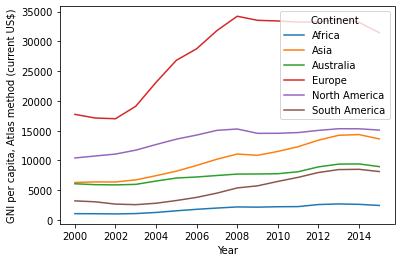

In [ ]:
#@title GNI per Capita Change over Time
x = continents_avg.reset_index()
x['Year'] = x['Year'].astype(int) 
y = x[x["Year"] >= 2000]
z= x[x[ "Year"]>= 1975]
z= x[x[ "Year"]<= 2010]


sns.lineplot(x = 'Year', y = "GNI per capita, Atlas method (current US$)",
             hue='Continent', data=y);

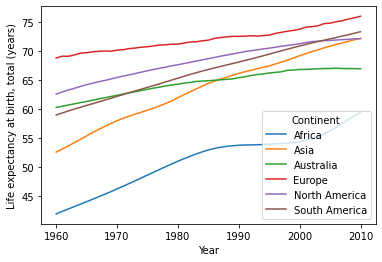

In [ ]:
#@title Life Expectancy at Birth over Time
sns.lineplot(x = 'Year', y = 'Life expectancy at birth, total (years)',
             hue='Continent', data=z);

## Immunization rate

In [ ]:
from scipy.stats import f_oneway
cleaned_health["Null Count"] = cleaned_health.isnull().sum(axis=1)
immunization = ['Immunization, BCG (% of one-year-old children)',
       'Immunization, DPT (% of children ages 12-23 months)',
       'Immunization, measles (% of children ages 12-23 months)',
       'Immunization, Pol3 (% of one-year-old children)']
health_immunization_all = cleaned_health[cleaned_health["Indicator Name"].isin(immunization)]
health_immunization_all = health_immunization_all[health_immunization_all['Null Count']<40]

# separated dataframe for different vaccine
health_immunization = [""]*4
for i in range(4):
  health_immunization[i] = cleaned_health[cleaned_health["Indicator Name"]==immunization[i]].sort_values(by = "Null Count")
  health_immunization[i] = health_immunization[i][health_immunization[i]['Null Count']<40]
  # print(i, health_immunization[i].isna().sum()) pick 1992 - 2015

year_range = [str(x) for x in range(1992, 2016)]
year_range.insert(0,"Country Code")
year_range.insert(1,"Country Name")
year_range.insert(2,"Indicator Name")
health_immunization_all = health_immunization_all[year_range].reset_index(drop=True)
for i in range(4):
  health_immunization[i] = health_immunization[i][year_range].reset_index(drop=True)

In [ ]:
# Anova code
year_range = [str(x) for x in range(1992, 2016)]
DPT = health_immunization[1][year_range].dropna().to_numpy()
measles = health_immunization[2][year_range].dropna().to_numpy()
Pol3 = health_immunization[3][year_range].dropna().to_numpy()
F, p = f_oneway(DPT, measles, Pol3)

Text(0.5, 1.0, 'Immunization(measles)% From 1992 - 2015')

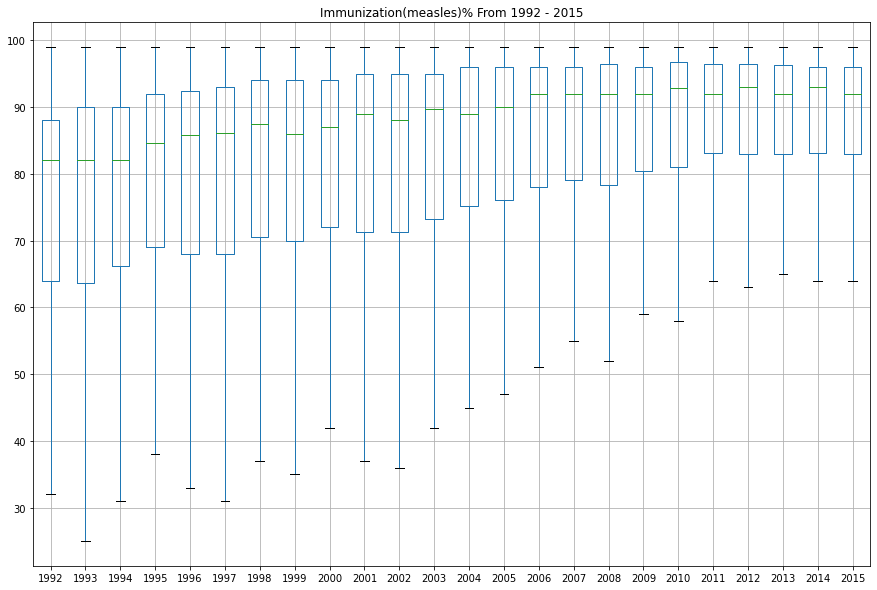

In [ ]:
measles_df = health_immunization[2]
measles_boxplot = measles_df.boxplot(figsize = (15,10),showfliers=False)
measles_boxplot.set_title("Immunization(measles)% From 1992 - 2015")

Text(0.5, 1.0, '# of countries with immunization rate > 85%')

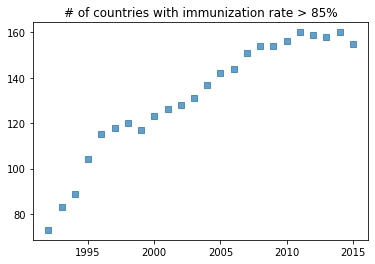

In [ ]:
measles_df_low_1992 = measles_df[measles_df['1992']<85] #142 countries
measles_df_low_2015 = measles_df[measles_df['2015']<85] #69 countries
measles_cnt = []
year = []
for i in range(1992, 2016):
  measles_cnt.append(measles_df['Indicator Name'][measles_df[str(i)]>85].count())

  year.append(i)
plt.scatter(x = year,y = measles_cnt,alpha = 0.7, marker = 's', cmap = "flare")
plt.title("# of countries with immunization rate > 85%")

Figure


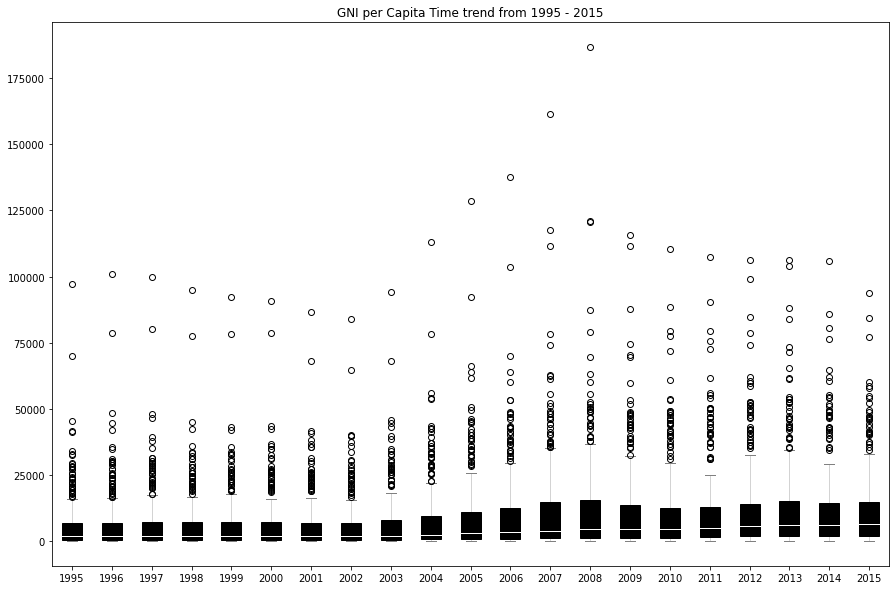

In [ ]:
#@title
# Time trends from 1995 - 2015 
health_gni = cleaned_health[health["Indicator Name"]=="GNI per capita, Atlas method (current US$)"]
health_gni = health_gni[health_gni['Null Count']<40] # 222 rows in total 
pd.set_option("display.max_rows", None, "display.max_columns", None)
#health_gni.isna().sum() # find yrs that has more data points 
year_range = [str(x) for x in range(1995, 2016)]
year_range.insert(0,"Country Code")
year_range.insert(1,"Country Name")
health_gni_analysis = health_gni[year_range].reset_index(drop=True)
props = dict(boxes="black", medians="white", caps="Gray", whiskers = "#D3D3D3")
gni_boxplot = health_gni_analysis.boxplot(figsize = (15,10),color = props, patch_artist=True,grid = False)
gni_boxplot.set_title("GNI per Capita Time trend from 1995 - 2015")
print("Figure")

The above figure shows the economical world trend from 1995 to 2015. Overall, it's excited to find a slightly increasing trend from 1995 to 2015. However, there are also lots of outliers with significantly higher GNI per capita than average, suggesting the vast differences in living standards among countries. <br>

To better understand the world trend of GNI per capita in the past 20 years, we divided countries into two groups (High-income economies and Non-high-income economies). By definition from [World Bank](https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups), high-income economies are countries with GNI per capita higher than $12,476. <br>

The figure below suggests that the non-high-income-economies countries (red boxes) show an overall increasing trend from 1995 to 2015 while high-income-economies countries (such as the US and many European countries) reach the peak in 2009 and then have a decreasing trend afterward. The 2008 economic crisis can probably explain the trend for high-income countries.

Figure


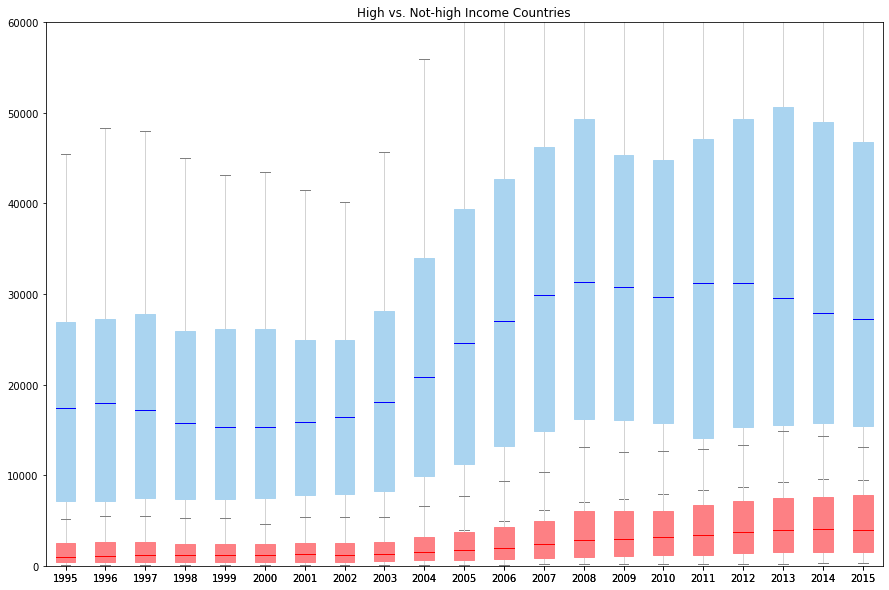

In [ ]:
#@title
high_income_countries = "Andorra,Greece,Palau, Antigua and Barbuda,Greenland,Panama Aruba,Guam,Poland, Australia,Portugal, Austria,Hungary,Puerto Rico, Bahamas,Iceland,Romania, Bahrain,Ireland,Qatar, Barbados,Isle of Man,San Marino, Belgium,Israel,Saudi Arabia, Bermuda,Italy,Seychelles, British Virgin Islands,Japan,Singapore, Brunei Darussalam,Korea,Sint Maarten (Dutch part), Canada,Kuwait,Slovak Republic, Cayman Islands,Latvia,Slovenia, Channel Islands,Liechtenstein,Spain, Chile,Lithuania,St. Kitts and Nevis, Croatia,Luxembourg,St. Martin (French part),Sweden, Cyprus,Malta,Switzerland, Czech Republic,Mauritius, Denmark,Monaco,Trinidad and Tobago, Estonia,Nauru,Turks and Caicos Islands, Faroe Islands,Netherlands,United Arab Emirates, Finland,New Caledonia,United Kingdom, France,New Zealand,United States, French Polynesia,Northern Mariana Islands,Uruguay, Germany,Norway,Virgin Islands (U.S.),Gibraltar,Oman".split(",")
high_income_countries = [x.strip() for x in high_income_countries]
high_income_group = health_gni_analysis[health_gni_analysis["Country Name"].isin(high_income_countries)]
props = dict(boxes="#AAD4F0", medians="Blue", caps="Gray", whiskers = "#D3D3D3")
props_2 = dict(boxes="#FD8084", medians="Red", caps="Gray", whiskers = "#D3D3D3")
high_income_boxplot = high_income_group.boxplot(figsize = (15,10),showfliers=False, color=props, patch_artist=True)
not_high_income_group = health_gni_analysis[~health_gni_analysis["Country Name"].isin(high_income_countries)]
not_high_income_boxplot = not_high_income_group.boxplot(grid = False,figsize = (15,10),showfliers=False,color = props_2, patch_artist=True)
not_high_income_boxplot.set_title("High vs. Not-high Income Countries")
not_high_income_boxplot.set_ylim(0,60000)
print("Figure")

#**Models**
**Objective:** Build a model that can predict what continent a country belongs to given limited data, including school enrollment, GNI per capita, population, life expectancy, etc.

## Preparing the Models

In [ ]:
cols = limited_nulls.columns.tolist()
cols = cols[-3:] + cols[:-3]
limited_nulls = limited_nulls[cols]
#limited_nulls

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})

In [ ]:
year_range = [str(x) for x in range(1960, 1981)]
limited_nulls = limited_nulls[~limited_nulls["Year"].isin(year_range)]
limited_nulls
selected_cols = ['Continent','Country Name','Year',
                 'School enrollment, tertiary (% gross)', 
                 'School enrollment, secondary (% gross)', 
                 'School enrollment, primary (% gross)',
                 'Immunization, measles (% of children ages 12-23 months)', 
                 'GNI per capita, Atlas method (current US$)',
 'Number of infant deaths',
 'Number of under-five deaths', 'Mortality rate, under-5 (per 1,000)',
 'Mortality rate, infant (per 1,000 live births)',
 'Mortality rate, adult, male (per 1,000 male adults)',
 'Mortality rate, adult, female (per 1,000 female adults)', 
 'Survival to age 65, female (% of cohort)',
 'Life expectancy at birth, total (years)',
 'Fertility rate, total (births per woman)', 
 'Age dependency ratio (% of working-age population)',
 'Population ages 00-14, total', 
 'Population, male',
 'Population, female', 
 'Death rate, crude (per 1,000 people)',
 'Birth rate, crude (per 1,000 people)',
 'Rural population growth (annual %)',
 'Urban population growth (annual %)',
 'Urban population',
 'Rural population',
 'Urban population (% of total)',
 'Rural population (% of total population)',
 'Population growth (annual %)',
 'Population, total',]
#limited_nulls.isna().sum()
selected_df = limited_nulls[selected_cols]

In [ ]:
# reformat to np 
selected_df_label = selected_df['Continent']
selected_df_label
selected_df_features = selected_df.loc[:, selected_df.columns != 'Continent']
selected_df_features = selected_df_features.loc[:, selected_df_features.columns != 'Country Name']

selected_df_features['Year'] = pd.to_numeric(selected_df_features['Year'])
features = selected_df_features.to_numpy()

In [ ]:
selected_df_label = selected_df_label.replace({'Asia': 0, 'Africa': 1,'Australia':2,'Europe':3,'North America':4, 'South America': 5,'Unknown':6})
label = selected_df_label.to_numpy()
#label
#features

## Neural Network
MulticlassClassification

### Extra Model (Feed Forward)

In [ ]:
class FeedForward(torch.nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(29, 200)
        self.fc2 = torch.nn.Linear(200, 200)
        self.fc3 = torch.nn.Linear(200, 7)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.nn.functional.log_softmax(x)

### Extra Model (CNN)


In [ ]:
class Convolutional(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=3,
                                 out_channels=7,
                                 kernel_size=3,
                                 stride=1,
                                 padding=0)
    self.pool = torch.nn.MaxPool2d(kernel_size = 2,stride = 2)
    self.conv2 = torch.nn.Conv2d(in_channels = 7, out_channels = 16, 
                                 kernel_size = 3, stride = 1, padding = 0)
    self.relu1 = torch.nn.ReLU()
    self.fc1 = torch.nn.Linear(2704,130)
    self.relu2 = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(130,72)
    self.relu3 = torch.nn.ReLU()
    self.fc3 = torch.nn.Linear(72,7)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, X):
    out = self.conv1(X)
    out = self.pool(out)
    out = self.conv2(out)
    out = self.relu1(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc1(out)
    out = self.relu2(out)
    out = self.fc2(out)
    out = self.relu3(out)
    out = self.fc3(out)
    out = self.sigmoid(out)
    return out

### Modeling, Training, and Evaluation

In [ ]:
class MulticlassClassification(torch.nn.Module):
    def __init__(self):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = torch.nn.Linear(29, 512)
        self.layer_2 = torch.nn.Linear(512, 128)
        self.layer_3 = torch.nn.Linear(128, 64)
        self.layer_out = torch.nn.Linear(64, 7) 
        
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.2)
        self.batchnorm1 = torch.nn.BatchNorm1d(512)
        self.batchnorm2 = torch.nn.BatchNorm1d(128)
        self.batchnorm3 = torch.nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [ ]:
class SelectedDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [ ]:
def train(model, data_loader, num_epochs, learning_rate):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(data_loader):
            images = torch.autograd.Variable(images.float())
            labels = torch.autograd.Variable(labels)

            optimizer.zero_grad()
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if (i + 1) % 50 == 0:
                y_true, y_predicted = evaluate(model, data_loader)
                """
                print(f'Epoch : {epoch}/{num_epochs}, '
                      f'Iteration : {i}/{len(data_loader)},  '
                      f'Loss: {loss.item():.4f},',
                      f'Train Accuracy: {100.* accuracy_score(y_true, y_predicted):.4f},',
                      f'Train F1 Score: {100.* f1_score(y_true, y_predicted, average="weighted"):.4f}')
                """

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    y_true = []
    y_predicted = []
    for images, labels in data_loader:
        images = torch.autograd.Variable(images.float())
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_predicted.extend(predicted)
    return y_true, y_predicted

In [ ]:
def plot_confusion_matrix(cm, class_names, title=None):
    plt.figure()
    if title:
        plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

### Running the Model

MulticlassClassification: Final Accuracy: 74.8948, Final F1 Score: 74.4063


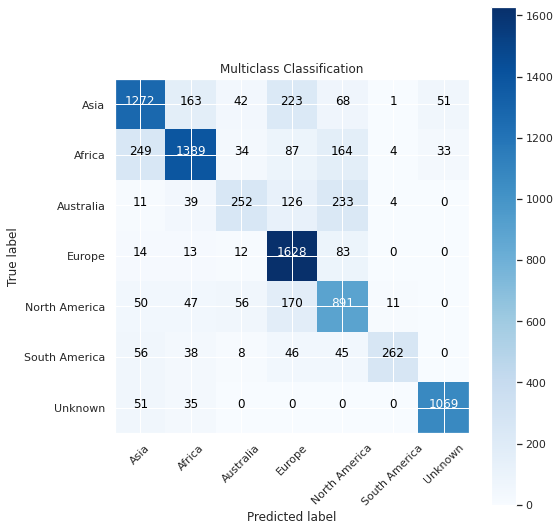

In [ ]:
#@title
# run model
class_names = ['Asia','Africa','Australia','Europe','North America','South America','Unknown']
num_epochs = 25
batch_size = 100
learning_rate = 0.001
data_loader = torch.utils.data.DataLoader(dataset=SelectedDataset(features, label),
                                              batch_size=batch_size,
                                              shuffle=True)
data_loader_reshaped = torch.utils.data.DataLoader(dataset=SelectedDataset(features, label),
                                                   batch_size=batch_size,
                                                   shuffle=True)
MulticlassClassification_model = MulticlassClassification()
train(MulticlassClassification_model, data_loader, 50, learning_rate)
y_true_easy, y_pred_easy = evaluate(MulticlassClassification_model, data_loader)
print(f'MulticlassClassification: '
          f'Final Accuracy: {100.* accuracy_score(y_true_easy, y_pred_easy):.4f},',
          f'Final F1 Score: {100.* f1_score(y_true_easy, y_pred_easy, average="weighted"):.4f}')
plot_confusion_matrix(confusion_matrix(y_true_easy, y_pred_easy), class_names, 'Multiclass Classification')

## Random Forest Classifier

In [ ]:
#@title Splitting the Data
train_label = label[:7030] # 7000 training data
test_label = label[7030:] # 2000 testing data
train_features = features[:7030]
test_features = features[7030:]

Test accuracy: 0.8285


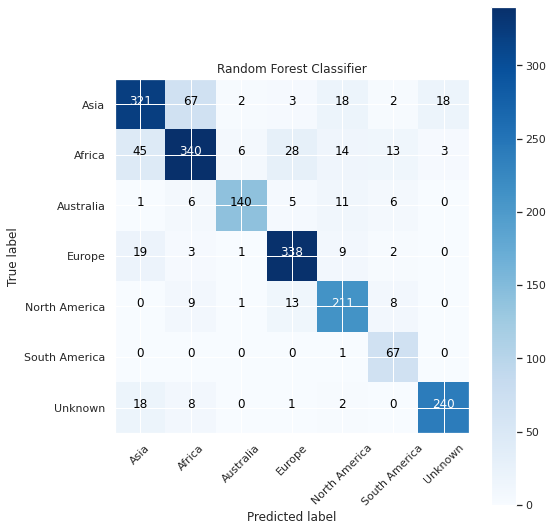

In [ ]:
#@title Running the Model

rfc = RandomForestClassifier(n_estimators = 29)
rfc.fit(train_features, train_label)
y_pred = rfc.predict(test_features)
acc = accuracy_score(test_label,y_pred)
print("Test accuracy:",acc)
plot_confusion_matrix(confusion_matrix(y_pred, test_label), class_names, 'Random Forest Classifier')

## (Extra model) Logistic Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(train_features, train_label)
y_pred_train = reg.predict(train_features)
y_pred = reg.predict(test_features)
mse_test = mean_squared_error(test_label, y_pred)
mse_train = mean_squared_error(train_label, y_pred_train)
print(mse_test,mse_train) # prove my guess, perform terrible 

2.928460179862511 2.609154001066198


## (Extra model) PCA + KMeans
The goal here is to see whether the continents tend to cluster together. It's accuracy as you see is poor since the best assignment of clusters yields an accuracy rate of ~51%

### Organizing the Data

In [ ]:
unsupervised_health = pivoted_health_continent
int_unsupervised_health = unsupervised_health.interpolate(method="linear")
y = int_unsupervised_health.groupby(["Country Name"]).mean()
int_unsupervised_health_data_avg = y

In [ ]:
nullcount = pd.DataFrame(int_unsupervised_health_data_avg.isna().sum())
nullcount.columns = ["Count"]

nullcount = nullcount[nullcount["Count"] == 0]

nullcount.columns = nullcount.columns.get_level_values(0)
nullcount.reset_index(inplace=True)
cols2 = nullcount['Indicator Name'].tolist()

int_unsupervised_health_data_avg_cleaned = int_unsupervised_health_data_avg[cols2]

y = int_unsupervised_health_data_avg.reset_index()[['Country Name']]
selected_cols = [
                 'School enrollment, tertiary (% gross)', 
                 'School enrollment, secondary (% gross)', 
                 'School enrollment, primary (% gross)',
                 'Immunization, measles (% of children ages 12-23 months)', 
                 'GNI per capita, Atlas method (current US$)',
 'Number of infant deaths',
 'Number of under-five deaths', 'Mortality rate, under-5 (per 1,000)',
 'Mortality rate, infant (per 1,000 live births)',
 'Mortality rate, adult, male (per 1,000 male adults)',
 'Mortality rate, adult, female (per 1,000 female adults)', 
 'Survival to age 65, female (% of cohort)',
 'Life expectancy at birth, total (years)',
 'Fertility rate, total (births per woman)', 
 'Age dependency ratio (% of working-age population)',
 'Population ages 00-14, total', 
 'Population, male',
 'Population, female', 
 'Death rate, crude (per 1,000 people)',
 'Birth rate, crude (per 1,000 people)',
 'Rural population growth (annual %)',
 'Urban population growth (annual %)',
 'Urban population',
 'Rural population',
 'Urban population (% of total)',
 'Rural population (% of total population)',
 'Population growth (annual %)',
 'Population, total',]

train_data = int_unsupervised_health_data_avg_cleaned[selected_cols]
y

Indicator Name,Country Name
0,Afghanistan
1,Albania
2,Algeria
3,American Samoa
4,Andorra
5,Angola
6,Antigua and Barbuda
7,Arab World
8,Argentina
9,Armenia


In [ ]:
mapper = DataFrameMapper([(train_data.columns, preprocessing.StandardScaler())])
scaled_features = mapper.fit_transform(train_data.copy(), 4)
scaled_features_df_4 = pd.DataFrame(scaled_features, index=train_data.index, columns=train_data.columns)

In [ ]:
predictions = pd.DataFrame()
pred4 = KMeans(n_clusters = 6, random_state=42).fit_predict(scaled_features_df_4)
predictions["LIM"] = pred4
pca= PCA(n_components = 2)
data_flattened_4 = pca.fit_transform(scaled_features_df_4)

x["Continent"] = y["Country Name"].map(continent_map)
predictions["Continent"] = x["Continent"]

**Finds Best Assignment of Continents to Clusters**

In [ ]:
perm = permutations([0, 1, 2, 3, 4, 5])  

perms = []
# Print the obtained permutations  
for i in list(perm):  
    x = {}
    for j in range(6):
        if i[j] == 0: x["Europe"] = j 
        elif i[j] ==1: x["North America"] = j
        elif i[j] ==2: x["South America"] = j
        elif i[j] ==3: x["Australia"] = j
        elif i[j] ==4: x["Asia"] = j
        else: x["Africa"] = j
    perms.append(x)

minerrorcombo = {}
minerror = 0

for p in perms:
    x = [p[i] for i in predictions["Continent"]]  
    acc = accuracy_score(pred4, x)
    if(acc > minerror):
      minerror = acc
      minerrorcombo = p

print(minerrorcombo, minerror)


{'North America': 0, 'Asia': 1, 'South America': 2, 'Australia': 3, 'Europe': 4, 'Africa': 5} 0.5155555555555555


**Using the optimal assignment to see if the k-means clusters are similar to the natural clustering of the countries**

X-Axis is PCA1 & Y-Axis is PCA2
Yellow: Africa
Light Green: Europe
Greenish Blue: Australia
Blue: South America
Purple: Asia
Accuracy Score:  0.5155555555555555


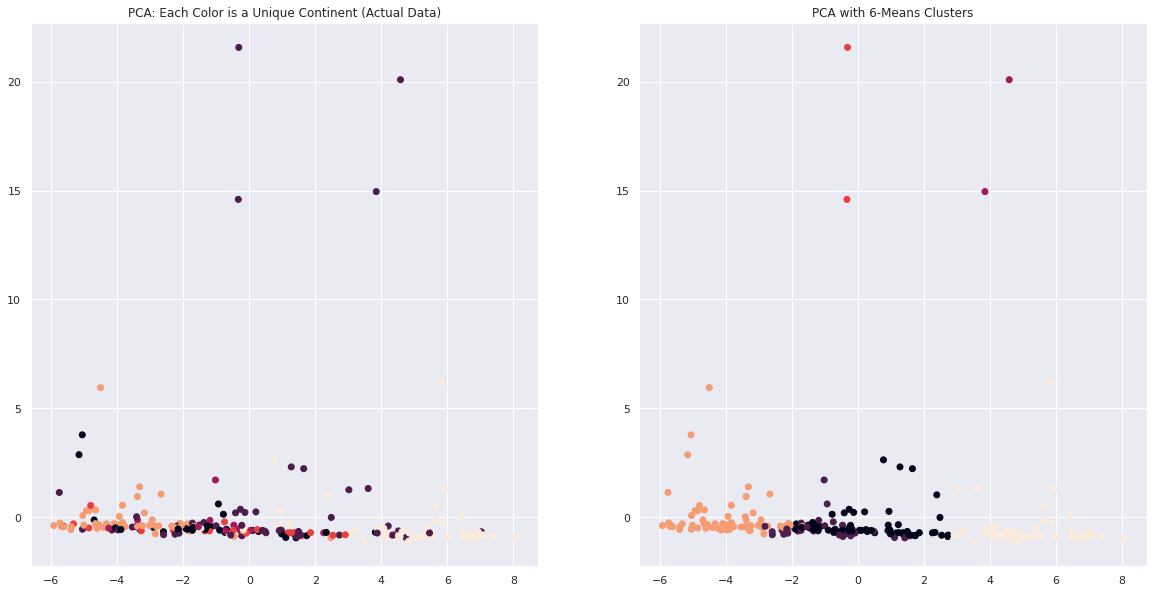

In [ ]:
colormap = {
    "Europe" : 4,
    "North America" : 0,
    "South America":2,
    "Africa" : 5,
    "Australia" : 3,
    "Asia" : 1
}

fig, axes =plt.subplots(1, 2, figsize=(20, 10))

axes[0].scatter(data_flattened_4[:,0],data_flattened_4[:,1],c = predictions["Continent"].map(colormap))
axes[1].set_title("PCA with 6-Means Clusters")

axes[1].scatter(data_flattened_4[:,0],data_flattened_4[:,1],c = pred4)
axes[0].set_title("PCA: Each Color is a Unique Continent (Actual Data)")

fig.show()
print("X-Axis is PCA1 & Y-Axis is PCA2")
print("Yellow: Africa")
print("Light Green: Europe")
print("Greenish Blue: Australia")
print("Blue: South America")
print("Purple: Asia")
print("Accuracy Score: ", minerror)